# Sell Optimization
Model training: **Optimal month**. Time series forecasting using LSTM networks
***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [2]:
# univariate lstm example
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten


from datetime import datetime
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


## Import dataset and create time series
The dataset is the monthly sales data for the product `Refridgerator` from year 2006 to 2020.   

In [3]:
drive_path = '/content/drive/MyDrive/'
local_path = 'Inframind/Customer retention/Sell optimization/'
df = pd.read_csv(drive_path+local_path+
  "refridgerator_sales.csv", 
  parse_dates=['Month'], 
  index_col="Month"
)

In [4]:
curr_date = datetime.strptime('2019-01-01', '%Y-%m-%d').date()

average = df.loc[datetime(year= curr_date.year -3, month =1, day = 1) : datetime(year = curr_date.year -1,month = 1, day= 1)].sum()/3


In [5]:
average

sales    400.333333
dtype: float64

In [6]:
df.tail()

,sales
Month,
2019-09-01,66
2019-10-01,78
2019-11-01,53
2019-12-01,52
2020-01-01,53


### Drop index 2020 having incomplete data

In [7]:
# drop last column because of incomplete data
df = df[:-1]


## Visualize the series

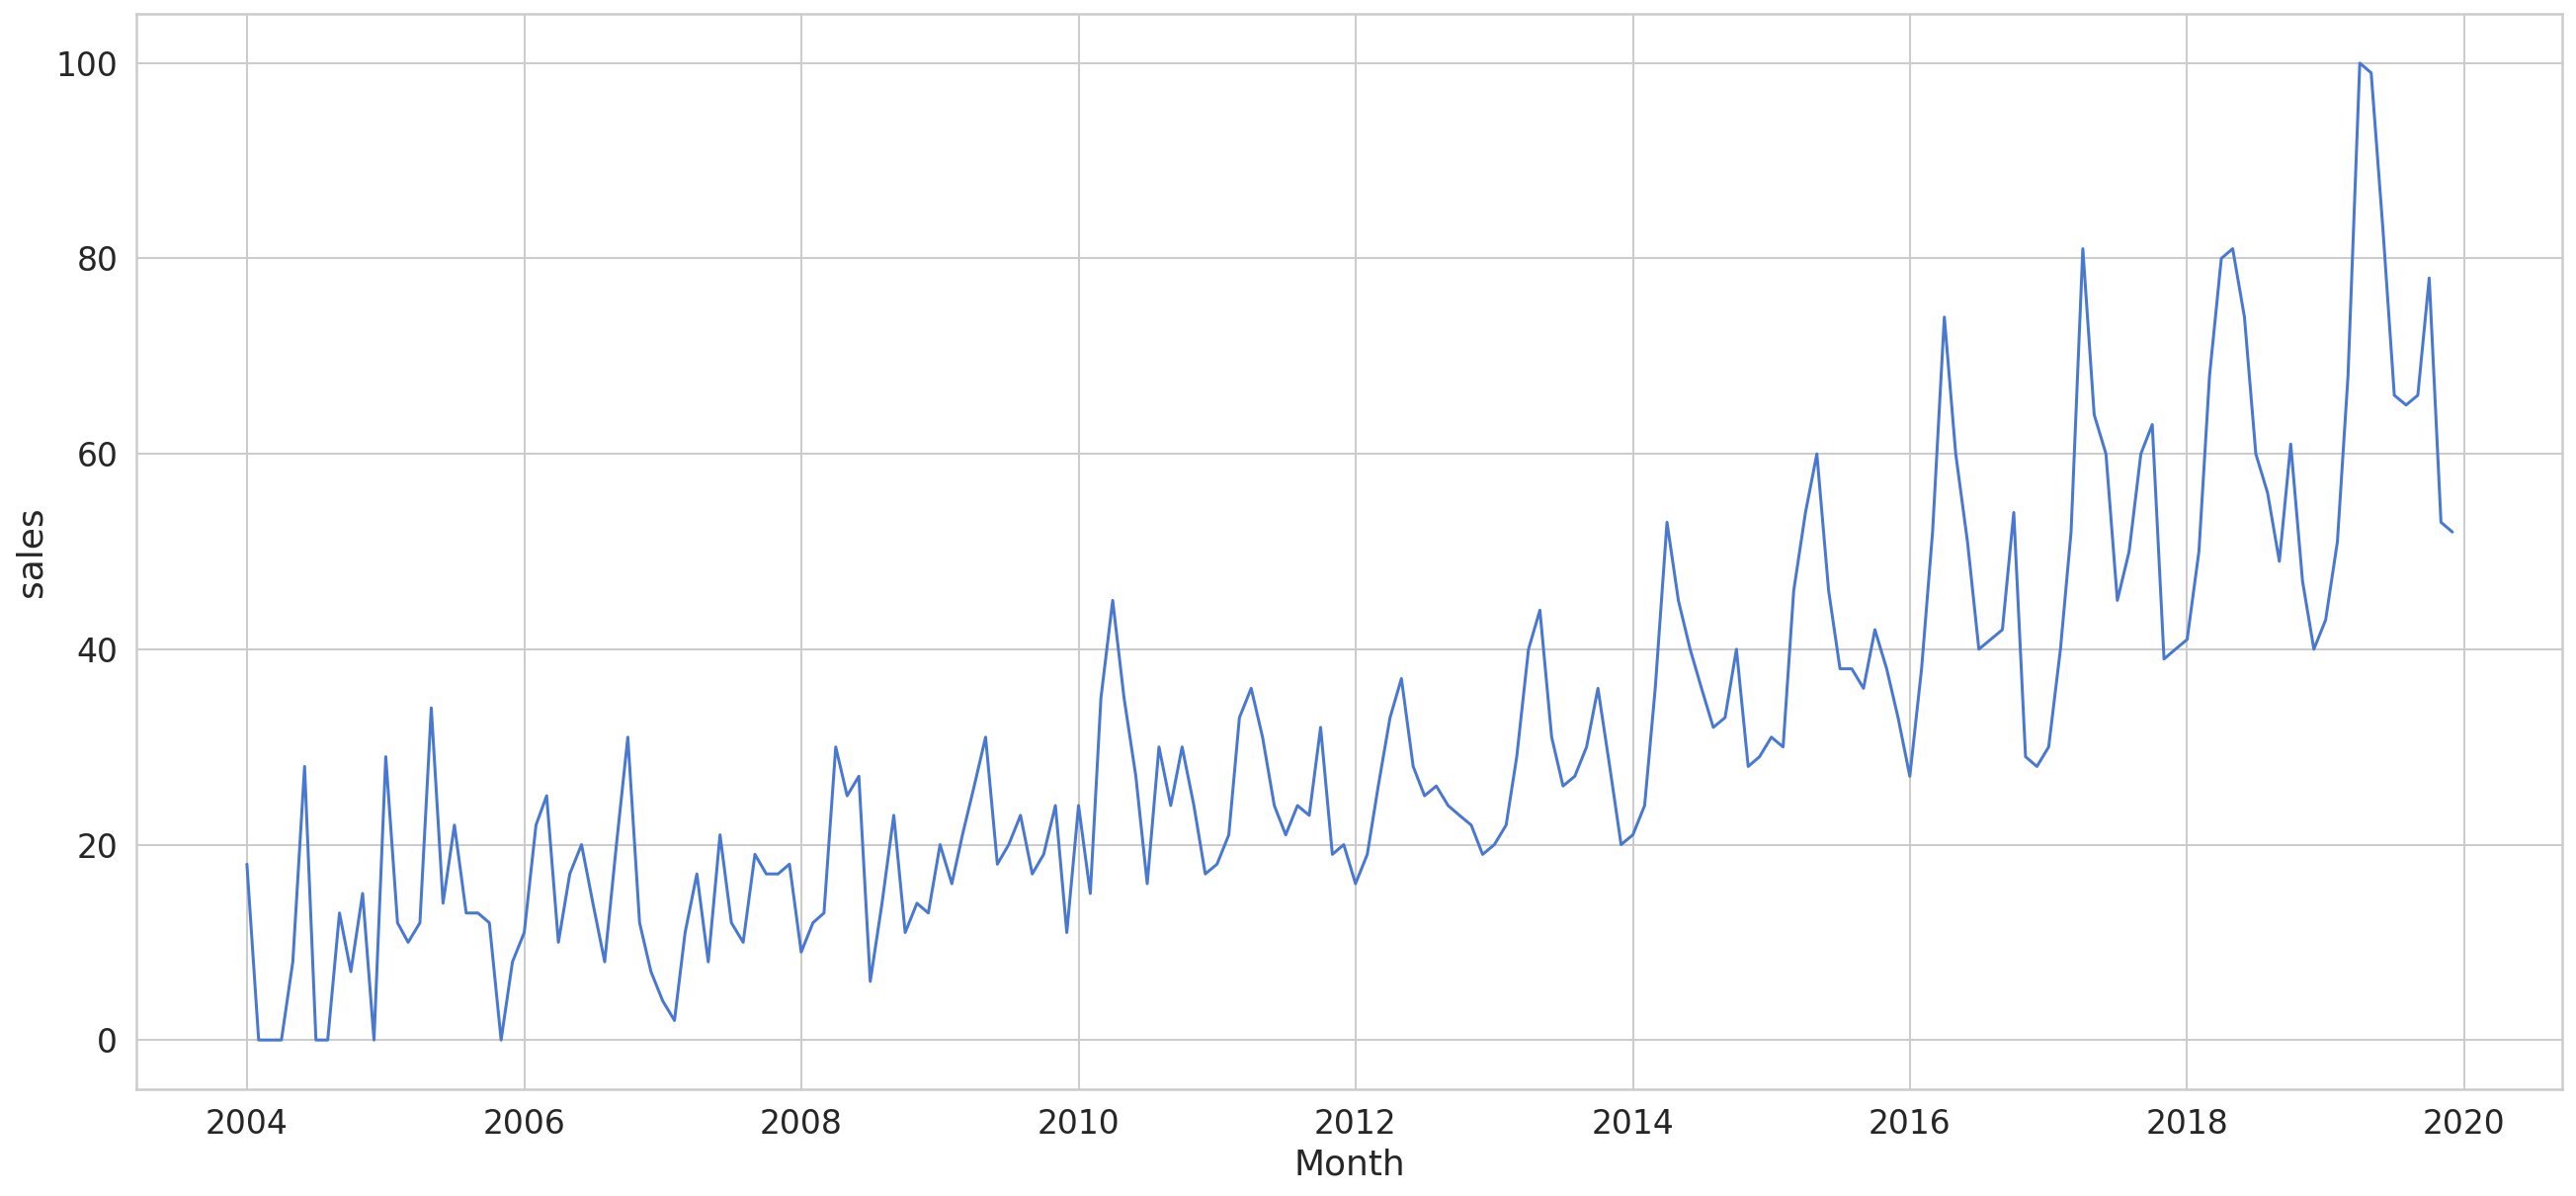

In [8]:
sns.lineplot(x=df.index, y="sales", data=df);


## Train test split

In [9]:
split_date = pd.datetime(2018,1,1)
train = df.loc[:split_date]
test = df.loc[split_date:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [10]:
train

,sales
Month,
2004-01-01,18
2004-02-01,0
2004-03-01,0
2004-04-01,0
2004-05-01,8
...,...
2017-09-01,60
2017-10-01,63
2017-11-01,39


In [11]:
test

,sales
Month,
2018-01-01,41
2018-02-01,50
2018-03-01,68
2018-04-01,80
2018-05-01,81
2018-06-01,74
2018-07-01,60
2018-08-01,56
2018-09-01,49


## Convert time series to supervised dataset

In [12]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

## Define time steps
The model will use the past 12 months time series data for the prediction of the next 12 months. 

In [13]:
time_steps = 12


X_train, y_train = create_dataset(train, train.sales, time_steps)
X_test, y_test = create_dataset(test, test.sales, time_steps)

print(X_train.shape, y_train.shape)

(157, 12, 1) (157,)


In [14]:
X_test

array([[[ 41],
        [ 50],
        [ 68],
        [ 80],
        [ 81],
        [ 74],
        [ 60],
        [ 56],
        [ 49],
        [ 61],
        [ 47],
        [ 40]],

       [[ 50],
        [ 68],
        [ 80],
        [ 81],
        [ 74],
        [ 60],
        [ 56],
        [ 49],
        [ 61],
        [ 47],
        [ 40],
        [ 43]],

       [[ 68],
        [ 80],
        [ 81],
        [ 74],
        [ 60],
        [ 56],
        [ 49],
        [ 61],
        [ 47],
        [ 40],
        [ 43],
        [ 51]],

       [[ 80],
        [ 81],
        [ 74],
        [ 60],
        [ 56],
        [ 49],
        [ 61],
        [ 47],
        [ 40],
        [ 43],
        [ 51],
        [ 68]],

       [[ 81],
        [ 74],
        [ 60],
        [ 56],
        [ 49],
        [ 61],
        [ 47],
        [ 40],
        [ 43],
        [ 51],
        [ 68],
        [100]],

       [[ 74],
        [ 60],
        [ 56],
        [ 49],
        [ 61],
        [ 47],


In [15]:
y_test

array([ 43,  51,  68, 100,  99,  83,  66,  65,  66,  78,  53,  52])

In [16]:
print(X_train),print(y_train)

[[[18]
  [ 0]
  [ 0]
  ...
  [ 7]
  [15]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [15]
  [ 0]
  [29]]

 [[ 0]
  [ 0]
  [ 8]
  ...
  [ 0]
  [29]
  [12]]

 ...

 [[29]
  [28]
  [30]
  ...
  [50]
  [60]
  [63]]

 [[28]
  [30]
  [40]
  ...
  [60]
  [63]
  [39]]

 [[30]
  [40]
  [52]
  ...
  [63]
  [39]
  [40]]]
[29 12 10 12 34 14 22 13 13 12  0  8 11 22 25 10 17 20 14  8 20 31 12  7
  4  2 11 17  8 21 12 10 19 17 17 18  9 12 13 30 25 27  6 14 23 11 14 13
 20 16 21 26 31 18 20 23 17 19 24 11 24 15 35 45 35 27 16 30 24 30 24 17
 18 21 33 36 31 24 21 24 23 32 19 20 16 19 26 33 37 28 25 26 24 23 22 19
 20 22 29 40 44 31 26 27 30 36 28 20 21 24 36 53 45 40 36 32 33 40 28 29
 31 30 46 54 60 46 38 38 36 42 38 33 27 38 52 74 60 51 40 41 42 54 29 28
 30 40 52 81 64 60 45 50 60 63 39 40 41]


(None, None)

In [17]:
y_train.shape

(157,)

In [18]:
X_train.shape

(157, 12, 1)

In [19]:
n_features = 1
print(X_train.shape)

(157, 12, 1)


## Filter integer residues

In [20]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)


print(X_train.dtype)
print(y_train.dtype)
print(X_test.dtype)
print(y_test.dtype)

float64
float64
float64
float64


## Building the LSTM Model

In [21]:
# define the model
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(time_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit the model
model.fit(X_train, y_train, epochs=300, verbose=1)


Epoch 1/300
5/5 [==============================] - 3s 40ms/step - loss: 703.8912
Epoch 2/300
5/5 [==============================] - 0s 51ms/step - loss: 131.0977
Epoch 3/300
5/5 [==============================] - 0s 34ms/step - loss: 88.4831
Epoch 4/300
5/5 [==============================] - 0s 41ms/step - loss: 85.4487
Epoch 5/300
5/5 [==============================] - 0s 36ms/step - loss: 81.3680
Epoch 6/300
5/5 [==============================] - 0s 39ms/step - loss: 68.3783
Epoch 7/300
5/5 [==============================] - 0s 37ms/step - loss: 71.9715
Epoch 8/300
5/5 [==============================] - 0s 52ms/step - loss: 107.8992
Epoch 9/300
5/5 [==============================] - 0s 39ms/step - loss: 62.3853
Epoch 10/300
5/5 [==============================] - 0s 33ms/step - loss: 50.9454
Epoch 11/300
5/5 [==============================] - 0s 37ms/step - loss: 41.8507
Epoch 12/300
5/5 [==============================] - 0s 39ms/step - loss: 43.7269
Epoch 13/300
5/5 [================

## Export the model

In [22]:
# save model
model.save('/content/drive/MyDrive/Inframind/Customer retention/Sell optimization/models/refridgerator_optimal_month.h5')

## Evaluate current year predictions

In [23]:
y_pred = model.predict(X_test)

In [24]:
y_pred

array([[45.460194],
       [47.253624],
       [62.95087 ],
       [81.88216 ],
       [87.11313 ],
       [77.222694],
       [63.67307 ],
       [65.37466 ],
       [66.16362 ],
       [67.84602 ],
       [41.884933],
       [43.977863]], dtype=float32)

In [25]:
 np.argmax(y_pred, axis=0)

array([4])

In [26]:
y_test

array([ 43.,  51.,  68., 100.,  99.,  83.,  66.,  65.,  66.,  78.,  53.,
        52.])

In [27]:
y_pred - y_test

array([[  2.46019363,  -5.53980637, -22.53980637, -54.53980637,
        -53.53980637, -37.53980637, -20.53980637, -19.53980637,
        -20.53980637, -32.53980637,  -7.53980637,  -6.53980637],
       [  4.25362396,  -3.74637604, -20.74637604, -52.74637604,
        -51.74637604, -35.74637604, -18.74637604, -17.74637604,
        -18.74637604, -30.74637604,  -5.74637604,  -4.74637604],
       [ 19.95087051,  11.95087051,  -5.04912949, -37.04912949,
        -36.04912949, -20.04912949,  -3.04912949,  -2.04912949,
         -3.04912949, -15.04912949,   9.95087051,  10.95087051],
       [ 38.88215637,  30.88215637,  13.88215637, -18.11784363,
        -17.11784363,  -1.11784363,  15.88215637,  16.88215637,
         15.88215637,   3.88215637,  28.88215637,  29.88215637],
       [ 44.11312866,  36.11312866,  19.11312866, -12.88687134,
        -11.88687134,   4.11312866,  21.11312866,  22.11312866,
         21.11312866,   9.11312866,  34.11312866,  35.11312866],
       [ 34.2226944 ,  26.2226944 ,

## Visualize current year predictions

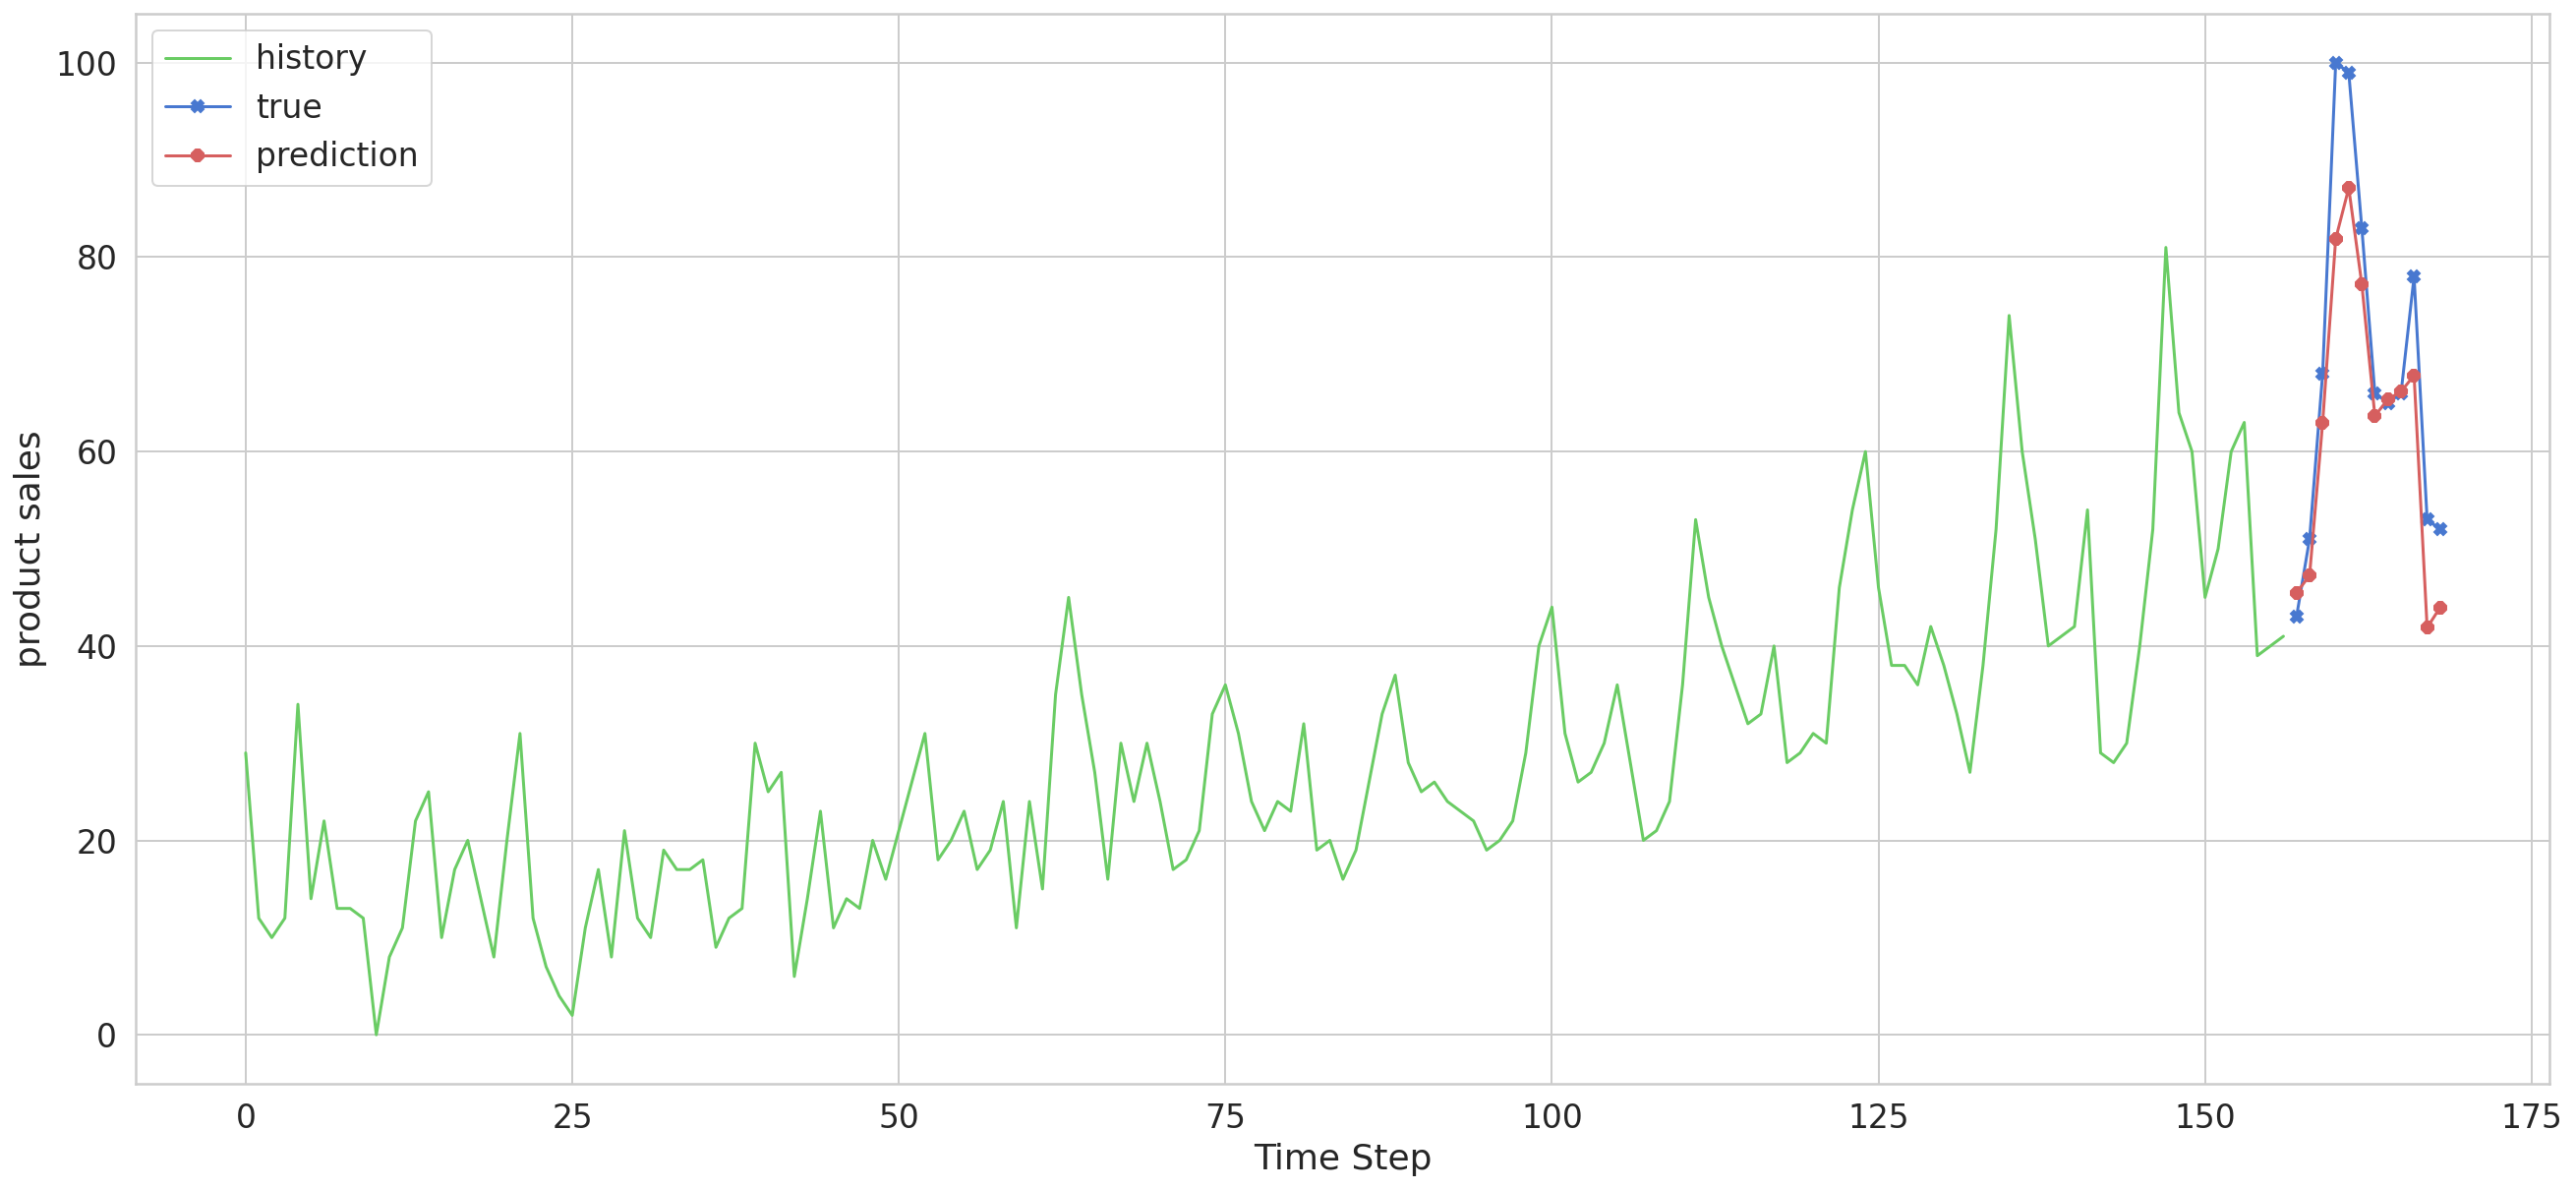

In [28]:
plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='X', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='8', label="prediction")
plt.ylabel('product sales')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [29]:
y_test

array([ 43.,  51.,  68., 100.,  99.,  83.,  66.,  65.,  66.,  78.,  53.,
        52.])

In [30]:
y_pred

array([[45.460194],
       [47.253624],
       [62.95087 ],
       [81.88216 ],
       [87.11313 ],
       [77.222694],
       [63.67307 ],
       [65.37466 ],
       [66.16362 ],
       [67.84602 ],
       [41.884933],
       [43.977863]], dtype=float32)